<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/transferencia_de_aprendizaje/xception_preentrenado_con_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de aprendizaje y ajuste fino

**Objetivo:** Se busca proveer de una guía en el aprendizaje por transferencia y ajuste fino, dos conceptos conocidos en inglés como *Transfer Learning & Fine-tuning* respectivamente. Se tomará como ejemplo la arquitectura Xception.

## Introducción

***Transfer Learning*** consiste en tomar los patrones aprendidos para resolver un problema y aprovecharlos para resolver otro similar. Por ejemplo, los patrones de un modelo que ya ha aprendido a identificar caballos pueden ser utilizados para entrenar un modelo destinado ahora a reconocer cebras.

El enfoque que propone el aprendizaje por transferencia comúnmente se aplica para tareas en las que el conjunto de datos contiene muy pocos registros para entrenar un modelo a gran escala desde cero.

Por lo general el aprendizaje por transferencia, dentro del contexto del  aprendizaje profundo, mantiene el siguiente flujo de implementación:

1. Se toman las capas de un modelo previamente entrenado para resolver una tarea similar.
2. Se "congelan" las capas del modelo para evitar destruir cualquier información contenida durante futuras iteraciones del entrenamiento.
3. Agregar algunas capas nuevas entrenables sobre las capas previamente congeladas. Éstas aprenderán a actualizar los patrones previos para la generación de predicciones sobre el nuevo conjunto de datos.
4. Entrenar las capas añadidas al conjunto de datos.

Un último paso opcional es el ***fine-tuning***, el cual consiste en descongelar todo el modelo (o parte de él), y volver a entrenarlo en los nuevos datos con una tasa de aprendizaje muy baja. Esto puede potencialmente lograr mejoras significativas al adaptar gradualmente los patrones preentrenadas a los nuevos datos.

Como ejemplo se implementará el flujo tomando un modelo previamente entrenado en el conjunto de datos de *ImageNet* para ahora entrenarlo en la clasificación de un nuevo conjunto de datos de Kaggle "gatos vs perros".

### Librerías

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers

#### Congelar capas

Las capas cuentan con tres atributos en relación a los parámetros del modelo:

- `weights`: Es la lista de todas las variables de pesos (parámetros) de la capa.
- `trainable_weights`: Es la lista de aquellos pesos que deben ser actualizados a través de gradiente descendente con el objetivo de minimizar la pérdida durante el entrenamiento.
- `non_trainable_weights`: Es la lista de aquellos pesos que no están destinados a ser entrenados. Por lo general, el modelo los actualiza durante el pase hacia adelante.

In [ ]:
# Ejemplo para una capa Densa con 3 unidades
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Creación de pesos

print("[INFO] weights:", len(layer.weights))
print("[INFO] trainable_weights:", len(layer.trainable_weights))
print("[INFO] non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


En general, todos los pesos son parámetros entrenables. La única capa integrada que tiene pesos no entrenables es la capa `BatchNormalization` ya que utiliza pesos no entrenables para realizar un seguimiento de la media y la varianza de sus entradas durante el entrenamiento.

**Ejemplo:**

In [ ]:
layer = tf.keras.layers.BatchNormalization()
layer.build((None, 4))  # Creación de pesos

print("[INFO] weights:", len(layer.weights))
print("[INFO] trainable_weights:", len(layer.trainable_weights))
print("[INFO] non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


Las capas de los modelos cuentan también con un atributo booleano `trainable`. Su valor puede ser cambiado. Establecer `layer.trainable` igual a `False` mueve todos los pesos de la capa entrenable a no entrenable, esto se llama "congelar" la capa, es decir, el estado de una capa congelada no será actualizado durante el entrenamiento (ya sea cuando se entrena con `fit()` o cuando se entrena con cualquier bucle personalizado que dependa de `trainable_weights` para aplicar actualizaciones de gradiente).

**Ejemplo:**

In [ ]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Creación de pesos
layer.trainable = False  # Congelar capas

print("[INFO] weights:", len(layer.weights))
print("[INFO] trainable_weights:", len(layer.trainable_weights))
print("[INFO] non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


Cuando un peso entrenable se vuelve no entrenable, su valor ya no se actualiza durante el entrenamiento.

In [ ]:
# Definición de un modelo con 2 capas
layer1 = tf.keras.layers.Dense(3, activation="relu")
layer2 = tf.keras.layers.Dense(3, activation="sigmoid")
model = tf.keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Congelar la primera capa
layer1.trainable = False

# Se guarda una copia de los pesos de la capa 1 para referencia posterior
initial_layer1_weights_values = layer1.get_weights()

# Entrenamiento de modelo
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Comprobar que los pesos de la capa 1 no hayan cambiado durante el entrenamiento
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(initial_layer1_weights_values[0], final_layer1_weights_values[0])
np.testing.assert_allclose(initial_layer1_weights_values[1], final_layer1_weights_values[1])

1/1 [==============================] - 5s 5s/step - loss: 0.0412


No confundir el atributo `layer.trainable` con el argumento `training` en `layer.__call__()` (que controla si la capa debe ejecutar su paso hacia adelante en modo de inferencia o modo de entrenamiento).

## Configuración recursiva del atributo `entrenable`

Si establece `trainable = False` en un modelo o en cualquier capa que tenga subcapas, todas las capas hijas también se vuelven no entrenables.

**Ejemplo:**

In [ ]:
inner_model = tf.keras.Sequential([tf.keras.Input(shape=(3,)),
                                   tf.keras.layers.Dense(3, activation="relu"),
                                   tf.keras.layers.Dense(3, activation="relu")])

model = tf.keras.Sequential([tf.keras.Input(shape=(3,)), inner_model, tf.keras.layers.Dense(3, activation="sigmoid"),])

model.trainable = False  # Congelar el modelo exterior

assert inner_model.trainable == False  # Todas las capas del modelo ahora están congeladas
assert inner_model.layers[0].trainable == False  # `trainable` se propaga recursivamente

## Ajuste fino de un modelo de clasificación

Para robustecer estos conceptos, se muestra un ejemplo punta a punta. Se cargará el modelo Xception pre-entrenado con ImageNet y se utilizará en el conjunto de datos de clasificación "gatos contra perros" de Kaggle.

### Obtener los datos

Primero, obtengamos el conjunto de datos de gatos contra perros usando TFDS. Transferir el aprendizaje es más útil cuando se trabaja con conjuntos de datos muy pequeños. Para mantener un conjunto de datos pequeño, se utilizará el 40% de los datos de entrenamiento originales (25,000 imágenes) para entrenamiento, 10% para validación y 10% para prueba.

In [ ]:
tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load("cats_vs_dogs",
                                             as_supervised=True,
                                             split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"])

print("[INFO] Número de muestras de entrenamiento: %d" % tf.data.experimental.cardinality(train_ds))
print("[INFO] Número de muestras de validación: %d" % tf.data.experimental.cardinality(validation_ds))
print("[INFO] Número de muestras de prueba: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


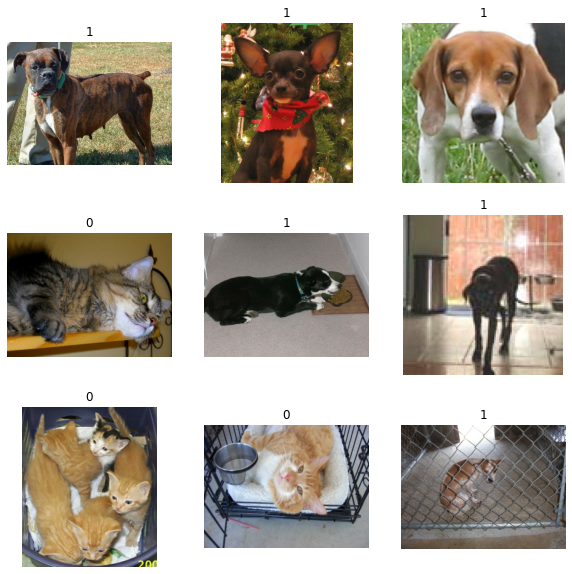

In [ ]:
# Primeras 9 imágenes en el conjunto de datos de entrenamiento
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Se puede identificar que todas las imágenes tienen distintos tamaños.

También que la etiqueta 1 se asigna a la categoría "perro" y la etiqueta 0 se asigna a la clase "gato".

### Estandarización de datos

Las imágenes del conjunto de datos cuentan con una amplia variedad de tamaños. Además, cada pixel consta de 3 enteros valores entre 0 y 255 (valores de nivel RGB). Esto no es muy adecuado para alimentar una red neuronal, por lo tanto, se deben aplicar 2 transformaciones:

- Estandarizar a un tamaño de imagen fijo como por ejemplo, 150x150
- Normalizar los valores de cada pixel entre -1 y 1.

En general, es una buena práctica desarrollar modelos que tomen datos sin procesar como entrada, a diferencia de los modelos que toman datos ya preprocesados, la razón es que, si el modelo espera recibir datos preprocesados, cada vez que se exporta el modelo para usarlo en otro entorno, como por ejemplo en un navegador web o en una aplicación móvil, se deberá volver a implementar exactamente el mismo *pipeline* de preprocesamiento. Esto se vuelve complejo rápidamente, así que se debería hacer la mínima cantidad posible de preprocesamiento antes de llegar al modelo.


In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Se agrupan los datos por lotes y se utiliza el almacenamiento en caché y se transfieren datos de la memoria principal al almacenamiento temporal para que estén listos para su uso posterior (*prefetch*), para optimizar la velocidad de carga.

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Aumentación de datos

Cuando no se tiene un conjunto de datos de imágenes grande, es una buena práctica introducir sintéticamente diversidad de muestras aplicando transformaciones (pero realistas) a las imágenes de entrenamiento, como cambios horizontales o pequeñas rotaciones. Esto ayuda a exponer al modelo a diferentes aspectos de los datos de entrenamiento mientras reduce el sobreajuste.

In [ ]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),])

Se visualiza la primera imagen del primer lote después de varias transformaciones aleatorias:

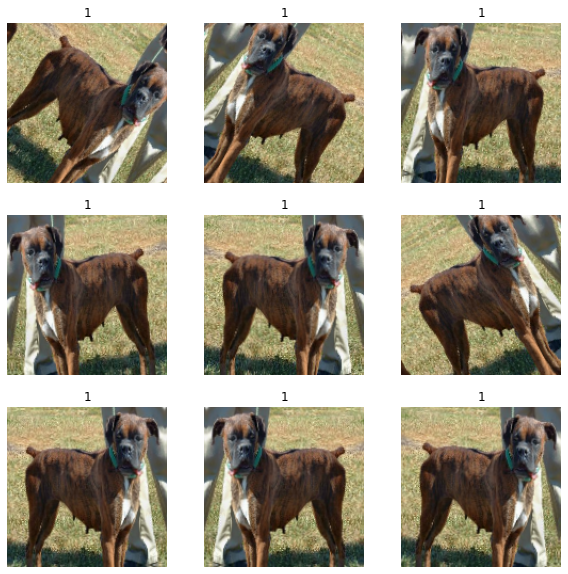

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

### Modelado

Ahora se construye un modelo que siga las características explicadas anteriormente.

Tener en cuenta que:

- Se agrega una capa de `Rescaling` para escalar los valores de entrada (inicialmente en el rango `[0, 255]`) al rango `[-1, 1]`.
- Se agrega una capa `Dropout` antes de la capa de clasificación, para añadir regularización.
- Nos aseguramos de pasar `training=False` al llamar al modelo base, para que se ejecute en modo inferencia, por lo que las estadísticas de normas por lotes no se actualizan incluso después de descongelar el modelo base para realizar ajustes.

In [ ]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

## Entrenamiento de modelo

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 41s 110ms/step - loss: 0.1682 - binary_accuracy: 0.9268 - val_loss: 0.0846 - val_binary_accuracy: 0.9652
Epoch 2/20
291/291 [==============================] - 26s 89ms/step - loss: 0.1166 - binary_accuracy: 0.9520 - val_loss: 0.0812 - val_binary_accuracy: 0.9673
Epoch 3/20
291/291 [==============================] - 26s 89ms/step - loss: 0.1092 - binary_accuracy: 0.9529 - val_loss: 0.0786 - val_binary_accuracy: 0.9703
Epoch 4/20
291/291 [==============================] - 26s 88ms/step - loss: 0.1103 - binary_accuracy: 0.9542 - val_loss: 0.0732 - val_binary_accuracy: 0.9703
Epoch 5/20
291/291 [==============================] - 26s 90ms/step - loss: 0.1081 - binary_accuracy: 0.9545 - val_loss: 0.0794 - val_binary_accuracy: 0.9686
Epoch 6/20
291/291 [==============================] - 26s 89ms/step - loss: 0.1023 - binary_accuracy: 0.9581 - val_loss: 0.0792 - val_binary_accuracy: 0.9686
Epoch 7/20
291/291 [==============================]

## Haga una ronda de ajuste fino de todo el modelo

Finalmente, descongelemos el modelo base y entrenemos todo el modelo de principio a fin con una tasa de aprendizaje baja.

Es importante destacar que, aunque el modelo base se vuelve entrenable, todavía se ejecuta en modo de inferencia ya que pasamos `training=False` cuando lo llamamos cuando construimos el modelo. Esto significa que las capas de normalización de lotes internas no actualizarán sus estadísticas de lotes. Si lo hicieran, causarían estragos en las representaciones aprendidas por el modelo hasta el momento.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

Después de 10 épocas, el ajuste fino nos brinda una buena mejora aquí.

## Transfiera el aprendizaje y ajuste con un ciclo de entrenamiento personalizado

Si en lugar de `fit()`, está utilizando su propio ciclo de entrenamiento de bajo nivel, el flujo de trabajo
permanece esencialmente igual. Debe tener cuidado de tener en cuenta solo la lista.
  `model.trainable_weights` al aplicar actualizaciones de gradiente:

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

Del mismo modo para el ajuste fino.

## El típico flujo de trabajo de aprendizaje por transferencia

Esto nos lleva a cómo se puede implementar un flujo de trabajo de aprendizaje de transferencia típico en Keras:

1. Cree una instancia de un modelo base y cargue pesos previamente entrenados en él.
2. Congele todas las capas en el modelo base configurando `trainable = False`.
3. Cree un nuevo modelo encima de la salida de una (o varias) capas de la base
  modelo.
4. Entrene su nuevo modelo en su nuevo conjunto de datos.

Tenga en cuenta que un flujo de trabajo alternativo y más ligero también podría ser:

1. Cree una instancia de un modelo base y cargue pesos previamente entrenados en él.
2. Ejecute su nuevo conjunto de datos y registre la salida de una (o varias) capas del modelo base. Esto se llama **extracción de características**.
3. Use esa salida como datos de entrada para un modelo nuevo y más pequeño.

Una ventaja clave de ese segundo flujo de trabajo es que solo ejecuta el modelo base una vez en
  sus datos, en lugar de una vez por época de entrenamiento. Así que es mucho más rápido y más barato.

Sin embargo, un problema con ese segundo flujo de trabajo es que no le permite dinámicamente
modifique los datos de entrada de su nuevo modelo durante el entrenamiento, lo cual es necesario al hacer
aumento de datos, por ejemplo. El aprendizaje por transferencia se usa típicamente para tareas cuando
su nuevo conjunto de datos tiene muy pocos datos para entrenar un modelo a gran escala desde cero, y en
tales escenarios el aumento de datos es muy importante. Así que en lo que sigue, nos centraremos
  en el primer flujo de trabajo.

Así es como se ve el primer flujo de trabajo en Keras:

Primero, crea una instancia de un modelo base con pesos previamente entrenados.

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

Luego, congela el modelo base.

```python
base_model.trainable = False
```

Crea un nuevo modelo.

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

Entrenar el modelo en datos nuevos.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## Ajuste fino

Una vez que su modelo haya convergido en los nuevos datos, puede intentar descongelar todo o parte de
  el modelo base y volver a entrenar todo el modelo de extremo a extremo con una tasa de aprendizaje muy baja.

Este es un último paso opcional que potencialmente puede brindarle mejoras incrementales.
  También podría conducir a un sobreajuste rápido, tenlo en cuenta.

Es fundamental realizar este paso solo *después* de que el modelo con capas congeladas haya sido
capacitados para la convergencia. Si mezcla capas entrenables inicializadas aleatoriamente con
Capas entrenables que contienen funciones preentrenadas, las capas inicializadas aleatoriamente
causar actualizaciones de gradiente muy grandes durante el entrenamiento, lo que destruirá su entrenamiento previo
  características.

También es fundamental usar una tasa de aprendizaje muy baja en esta etapa, porque
está entrenando un modelo mucho más grande que en la primera ronda de entrenamiento, en un conjunto de datos
  eso es típicamente muy pequeño.
Como resultado, corre el riesgo de sobreajustarse muy rápidamente si aplica mucho peso.
  actualizaciones Aquí, solo desea readaptar los pesos preentrenados de forma incremental.

Así es como se implementa el ajuste fino de todo el modelo base:

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**Nota importante sobre `compile()` y `entrenable`**

Llamar a `compile()` en un modelo está destinado a "congelar" el comportamiento de ese modelo. Esto
  implica que el `entrenable`
Los valores de los atributos en el momento en que se compila el modelo deben conservarse durante todo el
  toda la vida de ese modelo,
hasta que `compile` sea llamado de nuevo. Por lo tanto, si cambia cualquier valor 'entrenable', asegúrese de
  para llamar a `compile()` de nuevo en su
modelo para que sus cambios sean tomados en cuenta.

**Notas importantes sobre la capa `BatchNormalization`**

Muchos modelos de imagen contienen capas `BatchNormalization`. Esa capa es un caso especial en
  todos los conteos imaginables. Aquí hay algunas cosas a tener en cuenta.

- `BatchNormalization` contiene 2 pesos no entrenables que se actualizan durante
capacitación. Estas son las variables que siguen la media y la varianza de las entradas.
- Cuando establece `bn_layer.trainable = False`, la capa `BatchNormalization`
se ejecuta en modo de inferencia y no actualizará sus estadísticas de media y varianza. Esto no es
el caso de otras capas en general, como
[weight trainability & inference/training modes are two orthogonal concepts](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).

Pero los dos están empatados en el caso de la capa `BatchNormalization`.
- Cuando descongela un modelo que contiene capas `BatchNormalization` para hacer
ajuste fino, debe mantener las capas `BatchNormalization` en modo de inferencia
  pasando `training=False` al llamar al modelo base.
De lo contrario, las actualizaciones aplicadas a los pesos no entrenables destruirán repentinamente
lo que el modelo ha aprendido.

Verá este patrón en acción en el ejemplo completo al final de esta guía.

#### Referencias

* https://paperswithcode.com/method/xception
* https://paperswithcode.com/method/depthwise-separable-convolution
